### Data Exploration

In [1]:
import pandas as pd

# Load the training and test metadata
train_metadata = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv", low_memory=False)
test_metadata = pd.read_csv("/kaggle/input/isic-2024-challenge/test-metadata.csv", low_memory=False)

# Function to display columns with NaN values and their counts
def display_nan_columns(df, df_name):
    nan_counts = df.isna().sum()
    nan_counts = nan_counts[nan_counts > 0]
    if not nan_counts.empty:
        print(f"\nColumns with NaN values in {df_name}:")
        print(nan_counts)
    else:
        print(f"\nNo columns with NaN values in {df_name}.")

# Display columns with NaN values and their counts for training and test data
display_nan_columns(train_metadata, "training data")
display_nan_columns(test_metadata, "test data")



Columns with NaN values in training data:
age_approx               2798
sex                     11517
anatom_site_general      5756
lesion_id              379001
iddx_2                 399991
iddx_3                 399994
iddx_4                 400508
iddx_5                 401058
mel_mitotic_index      401006
mel_thick_mm           400996
dtype: int64

No columns with NaN values in test data.


In [2]:
print(len(train_metadata))
print(len(test_metadata))

401059
3


In [3]:
import pandas as pd

# Load the training and test metadata
train_metadata = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv", low_memory=False)
test_metadata = pd.read_csv("/kaggle/input/isic-2024-challenge/test-metadata.csv", low_memory=False)

# Compare columns in training and test data
train_columns = set(train_metadata.columns)
test_columns = set(test_metadata.columns)

# Columns present in training but not in test
train_not_in_test = train_columns - test_columns

# Columns present in test but not in training
test_not_in_train = test_columns - train_columns

print("Columns present in training but not in test:", train_not_in_test)
print("Columns present in test but not in training:", test_not_in_train)

# Columns that are common in both datasets
common_columns = train_columns & test_columns
print("Columns common in both training and test:", common_columns)


Columns present in training but not in test: {'iddx_full', 'iddx_3', 'lesion_id', 'iddx_1', 'iddx_2', 'iddx_4', 'iddx_5', 'target', 'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence'}
Columns present in test but not in training: set()
Columns common in both training and test: {'isic_id', 'tbp_lv_deltaL', 'tbp_lv_minorAxisMM', 'tbp_lv_H', 'clin_size_long_diam_mm', 'tbp_lv_areaMM2', 'age_approx', 'tbp_lv_Cext', 'tbp_lv_deltaA', 'tbp_lv_z', 'tbp_lv_L', 'attribution', 'tbp_lv_perimeterMM', 'tbp_lv_x', 'tbp_lv_stdLExt', 'tbp_lv_color_std_mean', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_Hext', 'tbp_lv_nevi_confidence', 'image_type', 'tbp_lv_C', 'copyright_license', 'tbp_lv_deltaB', 'tbp_lv_deltaLBnorm', 'tbp_lv_symm_2axis', 'anatom_site_general', 'tbp_lv_B', 'tbp_tile_type', 'sex', 'tbp_lv_y', 'tbp_lv_eccentricity', 'tbp_lv_deltaLB', 'tbp_lv_norm_color', 'tbp_lv_stdL', 'tbp_lv_Lext', 'patient_id', 'tbp_lv_radial_color_std_max', 'tbp_lv_location', 'tbp_lv_symm_2axis_angle', 'tbp_lv_

### Data Preparation

In [4]:
pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 45.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8
Note: you may need to restart the kernel to use updated packages.


Clustering, Dimensionality Reduction, then Both, with clustering evaluation


ROC AUC Score: 0.8117045170950836


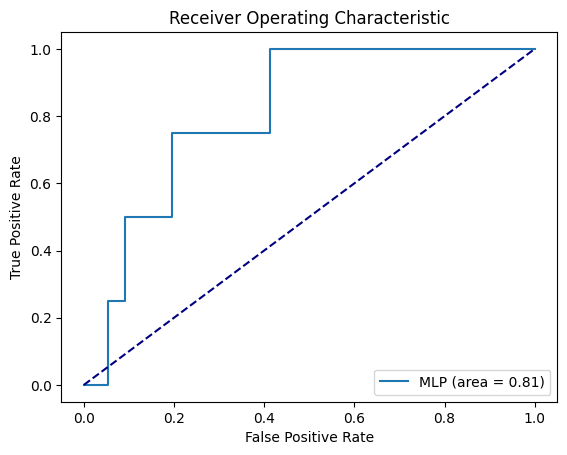

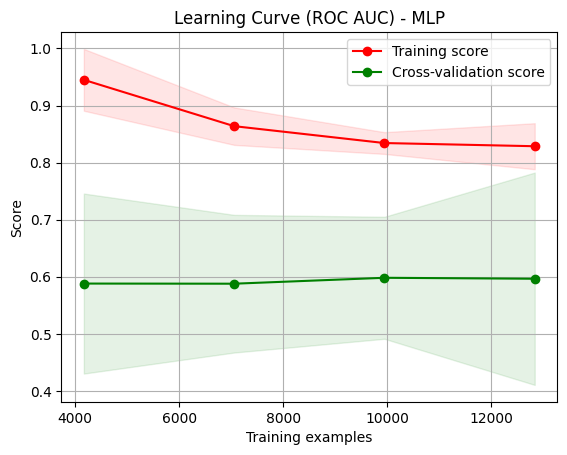

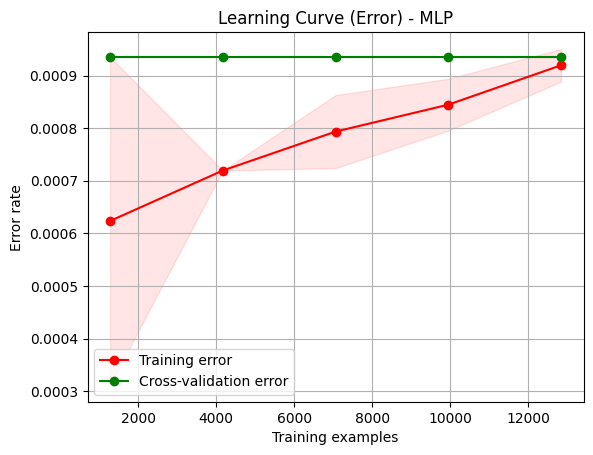

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from hdbscan import HDBSCAN
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neural_network import MLPClassifier
import joblib
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load the metadata
metadata = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv", low_memory=False)

# Use only 5% of the data for now
metadata_sampled = metadata.sample(frac=0.05, random_state=42)

# Preprocess the metadata
def preprocess_metadata(metadata, preprocessor=None, is_train=True):
    # Columns specific to training data
    drop_cols = ['mel_mitotic_index', 'mel_thick_mm', 'iddx_1', 'lesion_id', 'iddx_2', 'iddx_full', 'iddx_4', 'iddx_5', 'iddx_3', 'target', 'tbp_lv_dnn_lesion_confidence']
    
    metadata = metadata.drop(columns=[col for col in drop_cols if col in metadata.columns])

    # Define categorical and numerical columns
    categorical_cols = metadata.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = metadata.select_dtypes(include=['number']).columns.tolist()

    if preprocessor is None:
        # One-hot encode categorical variables and scale numerical variables
        preprocessor = ColumnTransformer(
            transformers=[
                ('num_imputer', SimpleImputer(strategy='mean'), numerical_cols),
                ('num_scaler', StandardScaler(), numerical_cols),
                ('cat', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_cols)])

        return preprocessor.fit(metadata), preprocessor.transform(metadata)
    else:
        metadata_imputed = preprocessor.named_transformers_['num_imputer'].transform(metadata[numerical_cols])
        metadata[numerical_cols] = metadata_imputed
        metadata_scaled = preprocessor.named_transformers_['num_scaler'].transform(metadata[numerical_cols])
        metadata[numerical_cols] = metadata_scaled
        metadata_encoded = preprocessor.named_transformers_['cat'].transform(metadata[categorical_cols])
        return np.hstack((metadata_scaled, metadata_encoded))

# Preprocess the metadata
preprocessor, metadata_processed = preprocess_metadata(metadata_sampled, is_train=True)
target = metadata_sampled['target']

# Ensure no NaN values remain
metadata_processed = np.nan_to_num(metadata_processed)

# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')

# Dimensionality reduction and clustering functions
def apply_tsne(X, n_components=2):
    tsne = TSNE(n_components=n_components, perplexity=min(30, X.shape[0] - 1))
    X_reduced = tsne.fit_transform(X)
    return X_reduced

def apply_hdbscan(X, min_cluster_size=5):
    hdbscan = HDBSCAN(min_cluster_size=min_cluster_size)
    clusters = hdbscan.fit_predict(X)
    return clusters

# Apply t-SNE for dimensionality reduction
X_reduced = apply_tsne(metadata_processed)

# Apply HDBSCAN for clustering
clusters = apply_hdbscan(X_reduced)

# Prepare data for the model
X_train, X_val, y_train, y_val = train_test_split(X_reduced, target, test_size=0.2, random_state=42)

# Define and train the MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Save the trained model and the dimensionality reduction method used
joblib.dump(mlp, 'mlp_model.pkl')

# Predict and evaluate
y_pred = mlp.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred)

print(f"ROC AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f'MLP (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Learning Curves
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5), scoring='roc_auc'):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score" if scoring == 'roc_auc' else "Error rate")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    
    if scoring == 'roc_auc':
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    else:
        train_error = 1 - train_scores_mean
        test_error = 1 - test_scores_mean
        plt.fill_between(train_sizes, train_error - train_scores_std,
                         train_error + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_error - test_scores_std,
                         test_error + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_error, 'o-', color="r", label="Training error")
        plt.plot(train_sizes, test_error, 'o-', color="g", label="Cross-validation error")

    plt.legend(loc="best")
    return plt

# Plot learning curve for ROC AUC
plot_learning_curve(mlp, "Learning Curve (ROC AUC) - MLP", X_train, y_train, cv=5, scoring='roc_auc')
plt.show()

# Plot learning curve for error (1 - accuracy)
plot_learning_curve(mlp, "Learning Curve (Error) - MLP", X_train, y_train, cv=5, scoring='accuracy')
plt.show()


### Next Steps

1. Model Complexity
2. Feature Engineering
3. Hyperparameter Tuning

### Model Training and Evaluation

### Inference

In [7]:
import pandas as pd
import joblib
import numpy as np
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Load the test metadata
test_metadata = pd.read_csv("/kaggle/input/isic-2024-challenge/test-metadata.csv", low_memory=False)

# Load the preprocessor and the trained model from the training process
preprocessor = joblib.load('preprocessor.pkl')
mlp = joblib.load('mlp_model.pkl')

# Preprocess the test data
def preprocess_metadata(metadata, preprocessor=None, is_train=True):
    # Columns specific to training data
    drop_cols = ['mel_mitotic_index', 'mel_thick_mm', 'iddx_1', 'lesion_id', 'iddx_2', 'iddx_full', 'iddx_4', 'iddx_5', 'iddx_3', 'target', 'tbp_lv_dnn_lesion_confidence']
    
    metadata = metadata.drop(columns=[col for col in drop_cols if col in metadata.columns])

    # Define categorical and numerical columns
    categorical_cols = metadata.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = metadata.select_dtypes(include=['number']).columns.tolist()

    if preprocessor is None:
        # One-hot encode categorical variables and scale numerical variables
        preprocessor = ColumnTransformer(
            transformers=[
                ('num_imputer', SimpleImputer(strategy='mean'), numerical_cols),
                ('num_scaler', StandardScaler(), numerical_cols),
                ('cat', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_cols)])
        return preprocessor.fit(metadata), preprocessor.transform(metadata)
    else:
        # Check if numerical columns are present
        if numerical_cols:
            metadata_imputed = preprocessor.named_transformers_['num_imputer'].transform(metadata[numerical_cols])
            metadata[numerical_cols] = metadata_imputed
            metadata_scaled = preprocessor.named_transformers_['num_scaler'].transform(metadata[numerical_cols])
            metadata[numerical_cols] = metadata_scaled
        else:
            metadata_scaled = np.empty((metadata.shape[0], 0))

        metadata_encoded = preprocessor.named_transformers_['cat'].transform(metadata[categorical_cols])
        return np.hstack((metadata_scaled, metadata_encoded))

test_metadata_processed = preprocess_metadata(test_metadata, preprocessor=preprocessor, is_train=False)

# Ensure no NaN values remain
test_metadata_processed = np.nan_to_num(test_metadata_processed)

# Apply t-SNE for dimensionality reduction
def apply_tsne(X, n_components=2):
    tsne = TSNE(n_components=n_components, perplexity=min(30, X.shape[0] - 1))
    X_reduced = tsne.fit_transform(X)
    return X_reduced

# Apply t-SNE on the processed test data
test_X_reduced = apply_tsne(test_metadata_processed)

# Predict using the trained MLP model
test_predictions = mlp.predict_proba(test_X_reduced)[:, 1]

# Prepare the submission file
submission = pd.DataFrame({
    'isic_id': test_metadata['isic_id'],
    'target': test_predictions
})

# Ensure the filename is correct
submission.to_csv('submission.csv', index=False)

print("Submission file generated.")
